# Recommendation System Project: IBM Community


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras + Concluding](#conclusions)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t


df = pd.read_csv(
    'data/user-item-interactions.csv', 
    dtype={'article_id': int, 'title': str, 'email': str}
)
# Show df to get an idea of the data
df.head()

,Unnamed: 0,article_id,title,email
0,0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` To ensure data consistency and prepare the dataset for further processing, we first check for missing values. If any missing values are found, we take appropriate actions based on the column affected - Missing email values: If the email column contains missing entries, we replace them with the placeholder string "unknown_user" to retain row integrity and enable downstream user identification logic.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int64 
 2   title       45993 non-null  object
 3   email       45976 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [3]:
print(f"Number of Null email values is: "+ str(df.email.isna().sum()))

Number of Null email values is: 17


In [4]:
# Checking if no more NaNs 
df[df.email.isna()]

,Unnamed: 0,article_id,title,email
25131,25146,1016,why you should master r (even if it might even...,NaN
29758,30157,1393,the nurse assignment problem,NaN
29759,30158,20,working interactively with rstudio and noteboo...,NaN
29760,30159,1174,breast cancer wisconsin (diagnostic) data set,NaN
29761,30160,62,data visualization: the importance of excludin...,NaN
35264,36016,224,"using apply, sapply, lapply in r",NaN
35276,36029,961,beyond parallelize and collect,NaN
35277,36030,268,sector correlations shiny app,NaN
35278,36031,268,sector correlations shiny app,NaN
35279,36032,268,sector correlations shiny app,NaN


`2.` We analyze how many articles each user interacts with to understand engagement patterns.

**Step 1**: Count the number of interactions per user.

**Step 2**: Display descriptive statistics.

**Step 3**: Visualize the distribution with a histogram.

In [5]:
df['article_id'].value_counts()

article_id
1429    937
1330    927
1431    671
1427    643
1364    627
       ... 
1344      1
984       1
1113      1
675       1
662       1
Name: count, Length: 714, dtype: int64

In [6]:
# What are the descriptive statistics of the number of articles a user interacts with?
user_article_counts = df.groupby('email')['article_id'].nunique()
desc_stats = user_article_counts.describe()
print("Descriptive Statistics:")
print(desc_stats)

Descriptive Statistics:
count    5148.000000
mean        6.540210
std         9.990676
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       135.000000
Name: article_id, dtype: float64


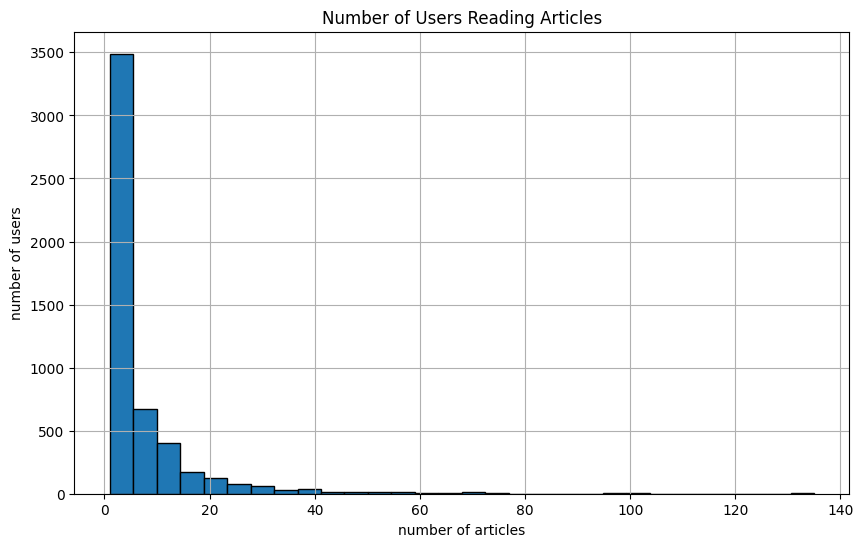

In [7]:
# Create a plot of the number of articles read by each user
plt.figure(figsize=(10,6))
plt.hist(user_article_counts, bins=30, edgecolor='black')
plt.grid(True)
plt.xlabel('number of articles')
plt.ylabel('number of users')
plt.title('Number of Users Reading Articles')
plt.show()

Descriptive Statistics:
count    714.000000
mean      47.155462
std       65.455913
min        1.000000
25%        7.000000
50%       21.500000
75%       59.000000
max      467.000000
Name: email, dtype: float64


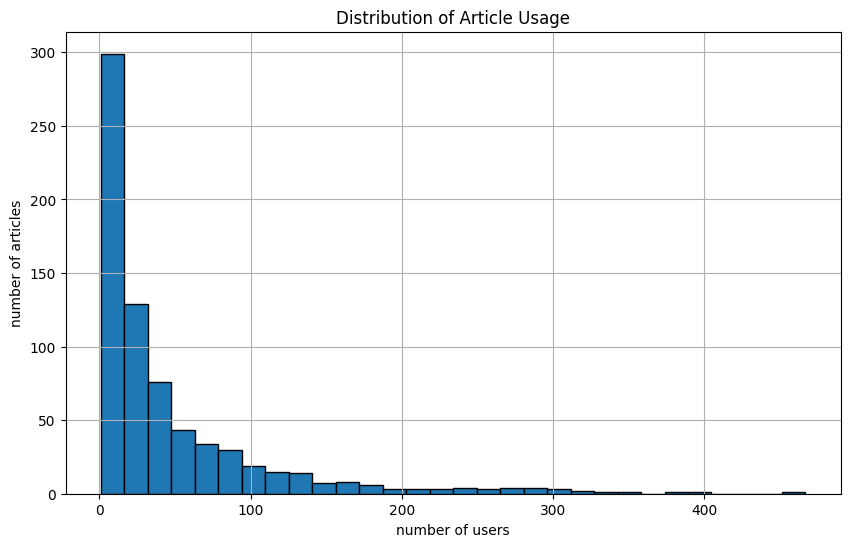

In [8]:
# Create a plot of the number of times each article was read
article_user_counts = df.groupby('article_id')['email'].nunique()
desc_stats = article_user_counts.describe()
print("Descriptive Statistics:")
print(desc_stats)

plt.figure(figsize=(10,6))
plt.hist(article_user_counts, bins=30, edgecolor='black')
plt.grid(True)
plt.xlabel('number of users')
plt.ylabel('number of articles')
plt.title('Distribution of Article Usage')
plt.show()

In [9]:
# Fill in the median and maximum number of user_article interactions below

median_val =  user_article_counts.median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user =  df.groupby('email')['article_id'].count().max() # The maximum number of user-article interactions by any 1 user is ______.
print(median_val, max_views_by_user)

3.0 364


`3.` We compute key metrics to understand the structure of the dataset:

**a**. Unique articles with interactions: Articles that have at least one user interaction.

**b**. Total unique articles: All distinct articles present in the dataset, regardless of interaction.

**c**. Unique users: Number of users with recorded interactions (excluding null user IDs).

**d**. Total interactions: Total number of user-article interaction events recorded.

In [10]:
unique_articles =  df['article_id'].nunique() # The number of unique articles that have at least one interaction
total_articles =  len(article_user_counts.index )# The number of unique articles on the IBM platform
unique_users =  len(user_article_counts.index) # The number of unique users
user_article_interactions =  len(df) # The number of user-article interactions
print(unique_articles)

714


`4.` To identify the most popular content, we determine:

- The **article_id** with the highest number of user interactions.

- The corresponding number of views.

In consultation with company leadership, we adopt the email_mapper function to handle missing user IDs. All null emails are mapped to a single identifier, "unknown_user", which is assumed to represent one anonymous user.

In [11]:
most_viewed_id = df['article_id'].value_counts().idxmax()
most_viewed_article_id = most_viewed_id #f"{most_viewed_id:.0f}"  # The most viewed article in the dataset as a string with one value following the decimal 
max_views =  df['article_id'].value_counts().max() # The most viewed article in the dataset was viewed how many times?
print(most_viewed_article_id, max_views)

1429 937


In [12]:
df.head()

,Unnamed: 0,article_id,title,email
0,0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [13]:
# Run this cell to map the user email to a user_id column and remove the email column

from recommendation import email_mapper

df['user_id'] = email_mapper(df)
del df['email']

# show header
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [14]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test dictionary against the solution
t.sol_1_test(sol_1_dict)

Oops! It looks like the value associated with: `The number of unique users in the dataset is ______` wasn't right. Try again.  It might just be the datatype.  All of the values should be ints except the article_id should be a string.  Let each row be considered a separate user-article interaction.  If a user interacts with an article 3 times, these are considered 3 separate interactions.

  Notice you may also find the number of unique users as 5149 if you count the null user.  However, this is hard to catch without mapping first!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this project, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [15]:
from recommender import RecommenderSystem
recommender = RecommenderSystem(df)

In [16]:
print(recommender.get_top_articles(10))
print(recommender.get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [17]:
# Test function by returning the top 5, 10, and 20 articles
top_5 = recommender.get_top_articles(5)
top_10 = recommender.get_top_articles(10)
top_20 = recommender.get_top_articles(20)

# Test each of three lists from above
t.sol_2_test(recommender.get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [18]:
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [19]:
# create the user-article matrix with 1's and 0's
from recommendation import create_user_item_matrix

user_item = recommender.user_item
user_item.head()#

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [21]:
# Lets use the cosine_similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity#

In [22]:
# Spot check of the function
print("The 10 most similar users to user 1 are: {}".format(recommender.find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(recommender.find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(recommender.find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 46, 4201, 824, 253, 5034, 5041, 2305, 136, 395]
The 5 most similar users to user 3933 are: [1, 4201, 46, 253, 5034]
The 3 most similar users to user 46 are: [4201, 790, 5077]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [23]:
# Check Results
recommender.get_article_names(recommender.user_user_recs( 1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'this week in data science (may 2, 2017)',
 'top 20 r machine learning and data science packages',
 'improving the roi of big data and analytics through leveraging new sources of data',
 'using apply, sapply, lapply in r',
 'awesome deep learning papers',
 'leverage python, scikit, and text classification for behavioral profiling',
 'challenges in deep learning',
 'do i need to learn r?',
 'how can data scientists collaborate to build better business']

In [24]:
from recommender import ContentBasedRecommender
cb_recommender = ContentBasedRecommender(df, user_item)
cb_recommender.get_ranked_article_unique_counts([1320, 232, 844])

[[1320, 123], [844, 78], [232, 62]]

In [25]:
# Test functions here - No need to change this code - just run this cell
assert set(cb_recommender.get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(cb_recommender.get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(recommender.get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(recommender.get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(recommender.get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(recommender.get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
assert cb_recommender.get_ranked_article_unique_counts([1320, 232, 844])[0] == [1320, 123], "Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.\nMake sure you are using the user_item matrix to create the article counts."
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [26]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = recommender.user_user_recs_ranked(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1162, 1165, 1185, 1293, 254, 40, 1271, 1328, 1402, 1410]

The top 10 recommendations for user 20 are the following article names:
['analyze energy consumption in buildings', 'analyze precipitation data', 'classify tumors with machine learning', 'finding optimal locations of new store using decision optimization', 'apple, ibm add machine learning to partnership with watson-core ml coupling', 'ensemble learning to improve machine learning results', 'customer demographics and sales', 'income (2015): united states demographic measures', 'uci: adult - predict income', 'uci: sms spam collection']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [27]:
print(recommender.get_top_sorted_users(1).head(n=1))
print(recommender.get_top_sorted_users(2).head(n=10))
print(recommender.get_top_sorted_users(131).head(n=10))

   neighbor_id  similarity  num_interactions
0         3933    0.986013              35.0
   neighbor_id  similarity  num_interactions
0         5083    0.730297               5.0
1         1552    0.577350               2.0
2         1890    0.577350               2.0
3         1372    0.471405               3.0
4         2941    0.433013               8.0
5         3586    0.408248               4.0
6          331    0.408248               1.0
7          348    0.408248               1.0
8          378    0.408248               1.0
9          496    0.408248               1.0
   neighbor_id  similarity  num_interactions
0         3870    0.986667              75.0
1          203    0.388909              96.0
2         4459    0.388909              96.0
3         3782    0.387585             135.0
4           40    0.384308              52.0
5         4932    0.384308              52.0
6           23    0.377647             135.0
7          242    0.375823              59.0
8         

In [28]:
### Tests with a dictionary of results
user1_most_sim = 3933 # Find the user that is most similar to user 1 
user2_6th_sim = 3586 # Find the 6th most similar user to user 2
user131_10th_sim = 383 # Find the 10th most similar user to user 131

In [29]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Answer:
For a new user, we cannot use any of the collaborative filtering functions above since they depend on past interactions. A better approach is to:
- Recommend the most popular articles system-wide, or
- Use content-based filtering or onboarding questions to match user preferences to articles

Top articles as no user history, only can use user-user history till they start having user-item iteractions

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [30]:
# What would your recommendations be for this new user 0?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = recommender.get_top_article_ids(10)

In [31]:
assert set(new_user_recs) == {1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330}, "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles.  Let's consider content to be the article **title**, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.  

`1.` Use the function bodies below to create a content based recommender function `make_content_recs`. We'll use TF-IDF to create a matrix based off article titles, and use this matrix to create clusters of related articles. You can use this function to make recommendations of new articles.

In [32]:
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int64 
 2   title       45993 non-null  object
 3   user_id     45993 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.4+ MB


In [34]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [35]:
# unique articles
df_unique_articles = df['title'].unique()
df_unique_articles_ids = df['article_id'].unique()

In [36]:
# Create a vectorizer using TfidfVectorizer and fit it to the article titles
max_features = 200
max_df = 0.75
min_df = 5

vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features,
)
print("Running TF-IDF")
X_tfidf = vectorizer.fit_transform(df_unique_articles) # Fit the vectorizer to the article titles

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf) # Fit the LSA model to the vectorized article titles
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Running TF-IDF
n_samples: 714, n_features: 125
Explained variance of the SVD step: 76.0%


Text(0.5, 0, 'Number of clusters')

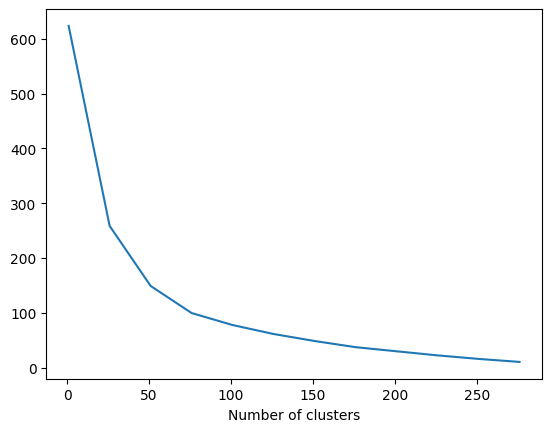

In [37]:
# Let's map the inertia for different number of clusters to find the optimal number of clusters
# We'll plot it to see the elbow
inertia = []
clusters = 300
step = 25
max_iter = 50
n_init = 5
random_state = 42
for k in range(1, clusters, step):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
    ).fit(X_lsa)
    # inertia is the sum of squared distances to the closest cluster center
    inertia.append(kmeans.inertia_)
plt.plot(range(1, clusters, step), inertia)
plt.xlabel('Number of clusters')

There appears to be an elbow about 50, so we'll use 50 clusters.

In [38]:
n_clusters = 50 # Number of clusters
kmeans = KMeans(
    # Your code here, same as parameters above
    n_clusters = 300,
    max_iter = 50,
    n_init = 5,
    random_state = 42,
    ).fit(X_lsa)

In [39]:
kmeans

,n_clusters,300
,init,'k-means++'
,n_init,5
,max_iter,50
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [40]:
# create a new column `title_cluster` and assign it the kmeans cluster labels
# First we need to map the labels to df_unique_articles article ids and then apply those to df
article_cluster_map = dict(zip(df_unique_articles_ids, kmeans.labels_))
 # Map article_id to cluster label
df['title_cluster'] = df['article_id'].map(article_cluster_map)# apply map to create title clusters

In [41]:
# Let's check the number of articles in each cluster
np.array(np.unique(kmeans.labels_, return_counts=True)).T

array([[  0,   4],
       [  1,  25],
       [  2,   1],
       [  3,   4],
       [  4,  20],
       [  5,  49],
       [  6,  20],
       [  7,   3],
       [  8,  19],
       [  9,  22],
       [ 10,   1],
       [ 11,   9],
       [ 12,  18],
       [ 13,   2],
       [ 14,  19],
       [ 15,   6],
       [ 16,   5],
       [ 17,   9],
       [ 18,   1],
       [ 19,  10],
       [ 20,   7],
       [ 21,   2],
       [ 22,   2],
       [ 23,   5],
       [ 24,   7],
       [ 25,  13],
       [ 26,   1],
       [ 27,   4],
       [ 28,   1],
       [ 29,   3],
       [ 30,   5],
       [ 31,   4],
       [ 32,   3],
       [ 33,   5],
       [ 34,   2],
       [ 35,   2],
       [ 36,   1],
       [ 37,   4],
       [ 38,   5],
       [ 39,   1],
       [ 40,   2],
       [ 41,   2],
       [ 42,   1],
       [ 43,   1],
       [ 44,   2],
       [ 45,   1],
       [ 46,   3],
       [ 47,   3],
       [ 48,   1],
       [ 49,   4],
       [ 50,   1],
       [ 51,   1],
       [ 52,

In [42]:
# Reinitialization
cb_recommender = ContentBasedRecommender(df, user_item)
# Test out your content recommendations given artice_id 25

rec_article_ids, rec_article_titles = cb_recommender.make_content_recs(25, 10)
print(rec_article_ids)
print(rec_article_titles)

[693, 48, 428]
['better together: spss and data science experience', 'data science experience documentation', 'data science experience demo: modeling energy usage in nyc']


In [43]:
def debug_make_content_recs(article_id, df=df, user_item=user_item):
    print("✅ Checking article exists in df:")
    print(df[df['article_id'] == article_id][['article_id', 'title', 'title_cluster']])

    print("\n✅ Checking articles in same cluster:")
    similar_articles = cb_recommender.get_similar_articles(article_id)
    print(similar_articles)

    print("\n✅ Checking user interaction counts:")
    print(cb_recommender.get_ranked_article_unique_counts(similar_articles))

debug_make_content_recs(25)


✅ Checking article exists in df:
       article_id                                 title  title_cluster
9479           25  creating the data science experience            233
10189          25  creating the data science experience            233
11369          25  creating the data science experience            233
25516          25  creating the data science experience            233
26434          25  creating the data science experience            233
29792          25  creating the data science experience            233
30392          25  creating the data science experience            233
32538          25  creating the data science experience            233
33931          25  creating the data science experience            233
34214          25  creating the data science experience            233
37178          25  creating the data science experience            233
41806          25  creating the data science experience            233
44554          25  creating the data science

In [44]:
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(rec_article_ids))) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function? What other text data would be useful to help make better recommendations besides the article title?

**Write an explanation of your content based recommendation system here.**

**Text Vectorization**
Each unique article title is transformed into a numerical vector using TF-IDF vectorization, which captures the importance of words across all titles while ignoring common stop words.

**Dimensionality Reduction (LSA)**
The high-dimensional TF-IDF vectors are then reduced using Truncated SVD (Latent Semantic Analysis) to capture latent topic relationships in a more compact representation.

**Clustering with KMeans**
These reduced vectors are clustered using KMeans, grouping similar articles based on their semantic content.

**Recommendation Logic**
- When a user views an article, we look up its cluster and recommend other articles from the same cluster.
- To improve recommendation quality, we rank those articles by popularity (number of unique users who interacted with them), ensuring the recommendations are not only similar but also engaging.

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to users.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [45]:
# quick look at the matrix
user_item.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) on the user-item matrix.  Use the cell to perform SVD.

In [46]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Using the full number of components which equals the number of columns
svd = TruncatedSVD(n_components=len(user_item.columns), n_iter=5, random_state=42)

u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_ 
print('u', u.shape)
print('s', s.shape)
print('vt', v.shape)

u (5149, 714)
s (714,)
vt (714, 714)


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain better metrics when making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how our metrics improve as we increase the number of latent features.

Text(0.5, 1.0, 'Metrics vs. Number of Latent Features')

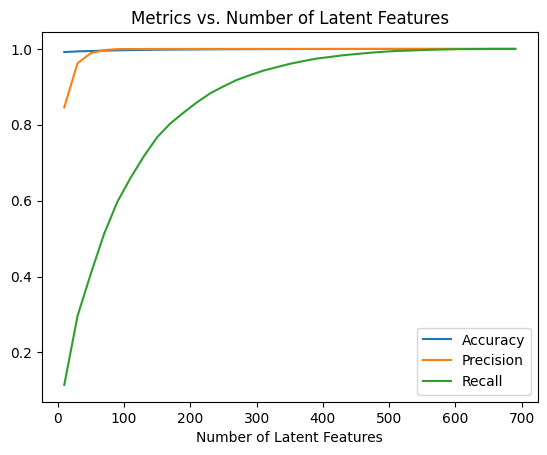

In [47]:
num_latent_feats = np.arange(10, 700+10, 20)
metric_scores = []

for k in num_latent_feats:
    # restructure with k latent features
    u_new, vt_new = u[:, :k], v[:k, :]
    
    # take dot product
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    # make sure the values are between 0 and 1
    user_item_est = np.clip(user_item_est, 0, 1)
    
    # total errors and keep track of them
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    metric_scores.append([acc, precision, recall])
    
    
plt.plot(num_latent_feats, metric_scores, label=['Accuracy', 'Precision', 'Recall'])
plt.legend()
plt.xlabel('Number of Latent Features')
plt.title('Metrics vs. Number of Latent Features')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Given the plot above, what would you pick for the number of latent features and why?

**Provide your response here.**

I would choose 300 latent features, as this provides a strong balance between accuracy, precision, and recall while avoiding unnecessary model complexity. The gains in recall beyond this point are marginal, and precision/accuracy have already saturated.

`5.` Using 200 latent features and the values of U, S, and V transpose we calculated above, create an article id recommendation function that finds similar article ids to the one provide.

Create a list of 10 recommendations that are similar to article with id 4.  The function should provide these recommendations by finding articles that have the most similar latent features as the provided article.

In [48]:
# Create a vt_new matrix with 200 latent features
k = 200
vt_new = v[:k, :]

In [49]:
# What is the article name for article_id 4?
print("Current article:", recommender.get_article_names([4])[0])

Current article: analyze ny restaurant data using spark in dsx


In [50]:
#Reinitialization
cb_recommender = ContentBasedRecommender(df, user_item, vt_new)
# What are the top 10 most similar articles to article_id 4?
rec_articles = cb_recommender.get_svd_similar_articles(4, 10)
rec_articles

[1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132]

In [51]:
# What are the top 10 most similar articles to article_id 4?
recommender.get_article_names(rec_articles)

['country statistics: crude oil - exports',
 'airbnb data for analytics: athens reviews',
 'use spark r to load and analyze data',
 'country statistics: crude oil - proved reserves',
 'top analytics tools in 2016',
 'airbnb data for analytics: paris calendar',
 'notebooks: a power tool for data scientists',
 '10 powerful features on watson data platform, no coding necessary',
 'advancements in the spark community',
 'collecting data science cheat sheets']

In [52]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

That's right!  Great job!


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make above are an improvement to how users currently find articles, either by Sections 2, 3, or 4? Add any tradeoffs between each of the methods, and how you could leverage each type for different situations including new users with no history, recently new users with little history, and users with a lot of history. 

**Using matrix factorization** with SVD allowed us to uncover latent relationships between users and articles by projecting both into a shared lower-dimensional space. In this space, we can identify articles similar in terms of collaborative behavior, rather than just title content or frequency of views.

For example, using 200 latent features, we were able to recommend articles that users with similar interaction histories also engaged with — this provides a form of collaborative filtering that captures more nuanced patterns than simple co-occurrence.

***User Scenarios***

**New Users (No History - Section 2 + 4)** :
    Use Rank-Based or Content-Based methods (e.g., top popular articles, or recommend by article cluster/title similarity).

**Cold Start Users (Minimal History - Section 2 + 4)**:
    Use a hybrid approach:

- Rank-based + content-based based on last seen article

- Fallback to collaborative filtering if possible

**Established Users (Lots of History - Section 3 + 5)**:
    Use SVD-based or user-user collaborative filtering — these leverage full interaction patterns and offer the best personalization.

To **evaluate the performance of the recommendation engine** in a real-world setting, we can design an experiment that measures how effectively the recommendations engage users. A robust experimental setup would include the following elements:
1. **Define Evaluation Metrics**
Before setting up the experiment, we need to define clear, quantifiable metrics. Metrics might include:

- Click-Through Rate (CTR): Proportion of recommended articles that the user clicks.

- Conversion Rate: Whether a clicked article leads to further interaction (e.g., saving, sharing).

- Engagement Time: Time spent reading or interacting with recommended articles.

2. Set Up an **A/B Testing** Framework
We can implement an A/B test to compare the performance of our recommendation system with a baseline. For example:

- Group A (Control): Receives standard popular articles (rank-based).

- Group B (Treatment): Receives personalized recommendations from our system.

    Both groups should be randomly assigned and statistically comparable in demographics and behavior history.

3. **Run the Experiment**

    The experiment should run for a sufficient duration to gather meaningful data (e.g., several weeks).

    We should log user interactions with recommendations for both groups.

    Monitor predefined metrics and ensure the sample size is large enough for statistical significance.

4. **Analyze Results**
After collecting data:

- Compare the metrics across both groups.

- Use statistical tests (e.g., t-tests, chi-square) to evaluate if the observed differences are significant.

- Segment analysis may reveal which user types benefit most from personalized recommendations.

5. Address **Potential Challenges**

- Cold-start users or articles: Use hybrid models combining rank-based and content-based methods
- Feedback loops (bias toward popular): Randomize some recommendations for exploration
- Low click volumes: Extend experiment duration or increase exposure frequency

6. **Iterate and Improve**

    Based on the experiment results, adjust model parameters, explore alternative models, or consider hybrid approaches.

    Regular A/B testing helps maintain relevance over time as user preferences evolve.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendation Systems project! 

## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [53]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb', '--to', 'pdf'])

[NbConvertApp] Converting notebook Recommendations_with_IBM.ipynb to pdf
[NbConvertApp] Support files will be in Recommendations_with_IBM_files/
[NbConvertApp] Making directory ./Recommendations_with_IBM_files
[NbConvertApp] Writing 142844 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 228680 bytes to Recommendations_with_IBM.pdf


0